In [67]:
!pip install tonic
!pip install snntorch



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import tonic
import tonic.transforms as transforms
import torch
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torchvision
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
dtype = torch.float
sensor_size=tonic.datasets.NMNIST.sensor_size
frame_transform= transforms.Compose([transforms.Denoise(filter_time=10000), transforms.ToFrame(sensor_size=sensor_size, time_window=10000)])
trainset= tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset= tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)  
transform= tonic.transforms.Compose([torch.from_numpy, torchvision.transforms.RandomRotation([-10, 10])])
cached_trainset= DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')
cached_testset= DiskCachedDataset(testset, cache_path='./cache/nmnist/test') 
batch_size=128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
spike_grad = surrogate.atan()
beta = 0.5
num_steps = 30
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)


In [69]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
temporal_loss = nn.MSELoss()

In [ ]:
static_time_threshold = 7# some constant < num_steps
def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)
  temporal_l = 0
  for step in range(data.size(0)):
    
    spk_out, _ = net(data[step])
    spk_rec.append(spk_out)
    if step < static_time_threshold:
      for image in range(128):#spk_out.size()):
        temporal_l += temporal_loss(spk_out[image], torch.zeros_like(spk_out[image]))
  print('temporal l', temporal_l)
  return [torch.stack(spk_rec), temporal_l]

In [ ]:
num_epochs = 1
num_iters = 100

loss_hist = []
acc_hist = []
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        # 1 x 298 x 2 x 34 x 34
        data = data.to(device)
        targets = targets.to(device)
        
        # sets the model to training mode
        net.train()
        
        # forward pass, find what neurons spiked & calculate temporal loss
        spk_rec, temporal_l = forward_pass(net, data)

        # compute the value loss
        loss_val = loss_fn(spk_rec, targets)
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")
        # add temporal loss to total loss
        loss_val += temporal_l # * alpha

        # backward pass
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # record loss
        loss_hist.append(loss_val.item())

        print(f"With temporal loss: Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")
        # print(f"Temporal Loss (first {temporal_threshold} steps): {temp_loss.item():.2f}")
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")
        # training loop breaks after 50 iterations
        if i == num_iters:
          break



31
temporal l tensor(0., grad_fn=<AddBackward0>)
Epoch 0, Iteration 0 
Train Loss: 2.90
With temporal loss: Epoch 0, Iteration 0 
Train Loss: 2.90
Accuracy: 7.03%

31
temporal l tensor(0., grad_fn=<AddBackward0>)
Epoch 0, Iteration 1 
Train Loss: 2.90
With temporal loss: Epoch 0, Iteration 1 
Train Loss: 2.90
Accuracy: 7.03%

31
temporal l tensor(0., grad_fn=<AddBackward0>)
Epoch 0, Iteration 2 
Train Loss: 2.90
With temporal loss: Epoch 0, Iteration 2 
Train Loss: 2.90
Accuracy: 7.81%

31
temporal l tensor(0., grad_fn=<AddBackward0>)
Epoch 0, Iteration 3 
Train Loss: 2.90
With temporal loss: Epoch 0, Iteration 3 
Train Loss: 2.90
Accuracy: 13.28%

31
temporal l tensor(0., grad_fn=<AddBackward0>)
Epoch 0, Iteration 4 
Train Loss: 2.90
With temporal loss: Epoch 0, Iteration 4 
Train Loss: 2.90
Accuracy: 10.16%

31
temporal l tensor(0., grad_fn=<AddBackward0>)
Epoch 0, Iteration 5 
Train Loss: 2.90
With temporal loss: Epoch 0, Iteration 5 
Train Loss: 2.90
Accuracy: 9.38%

31
temporal l 

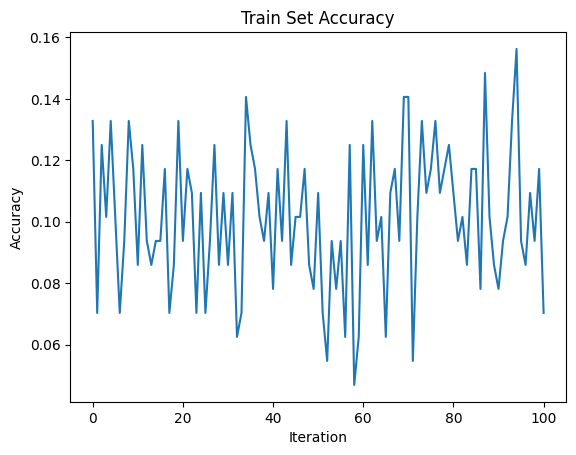

In [ ]:


# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()